# ARIMA

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# To avoid seeing warnings
import warnings
warnings.filterwarnings('ignore')

df1 = pd.read_csv('../UPDATE_TSA_NOTEBOOKS/Data/TradeInventories.csv', index_col='Date', parse_dates=True)
df1.index.freq = 'MS'
df1.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


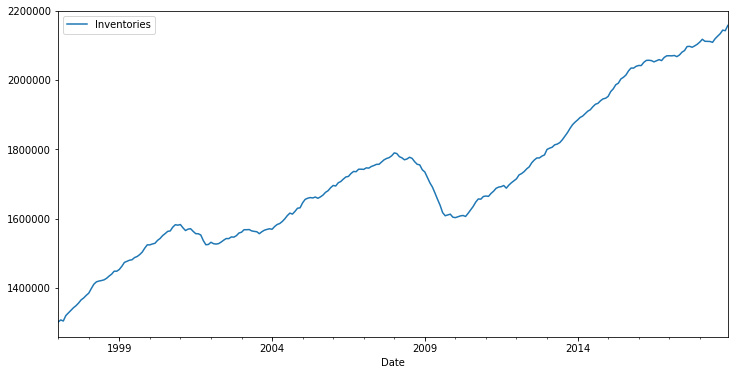

In [87]:
df1.plot(figsize=(12,6));

### 1. ETS Decomposition

In [88]:
# Importando Libreria para descomposición de la series temporal
from statsmodels.tsa.seasonal import seasonal_decompose

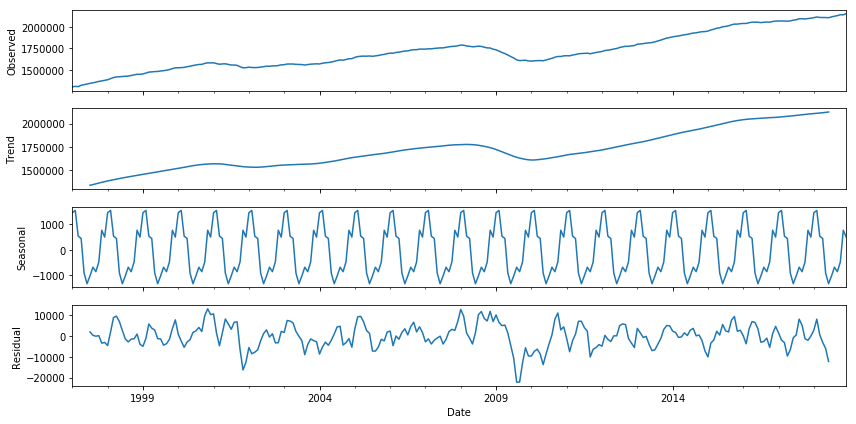

In [89]:
result = seasonal_decompose(df1['Inventories'],model='add')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
result.plot();

___Seasonal values are between -1000 and 1000 and the values in this Time Series are around 1E6___

___This means that Seasonal effects don't affect our model___

### 2. Pyramid ARIMA

In [90]:
# Non Stationary Dataset
from pmdarima import auto_arima
# In this case the dataset has seasonality and m is monthly = 12
stepwise_fit = auto_arima(df1['Inventories'],seasonal=False,trace=True)
print(stepwise_fit)
# Best Model
stepwise_fit.summary()

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.101 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.112 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.841, Fit time=0.138 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.527, BIC=5247.387, Fit time=0.317 seconds
Fit ARIMA: order=(3, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.157 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.289, BIC=5247.150, Fit time=0.250 seconds
Total fit time: 1.166 seconds
ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Fri, 03 May 2019   AIC                           5228.505
Time:                        17:53:10   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3463.1822   1313.137      2.637      0.009     889.481    6036.884
ar.L1.D.y      0.9037      0.039     23.413      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

### 2. Diff and Dickey-Fuller Test

- Check if Differencing once makes the TS Stationary
- Check this with Dickey-Fuller Test

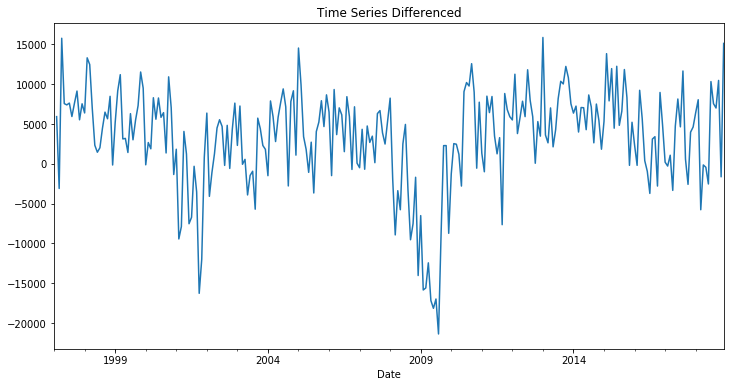

In [91]:
# Differencing once
from statsmodels.tsa.statespace.tools import diff
df1['Diff_1'] = diff(df1['Inventories'],k_diff=1)
df1['Diff_1'].plot(figsize=(12,6),title='Time Series Differenced');

In [92]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [93]:
adf_test(df1['Inventories'],'Dickey-Fuller Test No Diff')

Augmented Dickey-Fuller Test: Dickey-Fuller Test No Diff
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [94]:
adf_test(df1['Diff_1'],'Dickey-Fuller Test Diff Once')

Augmented Dickey-Fuller Test: Dickey-Fuller Test Diff Once
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 3. ACF PACF

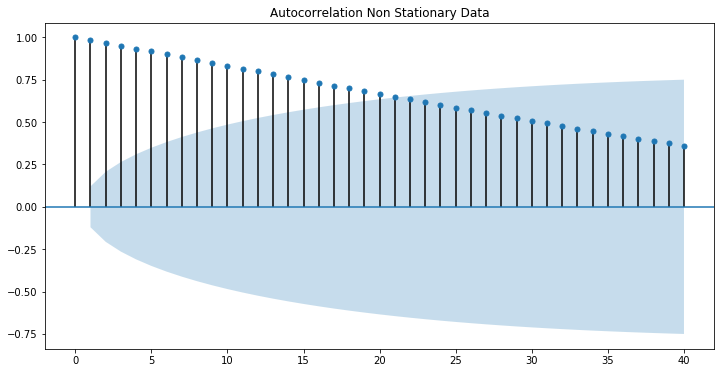

In [95]:
from statsmodels.graphics.tsaplots import plot_acf
# just 40 lags is enough
plot_acf(df1['Inventories'],lags=40,title='Autocorrelation Non Stationary Data');

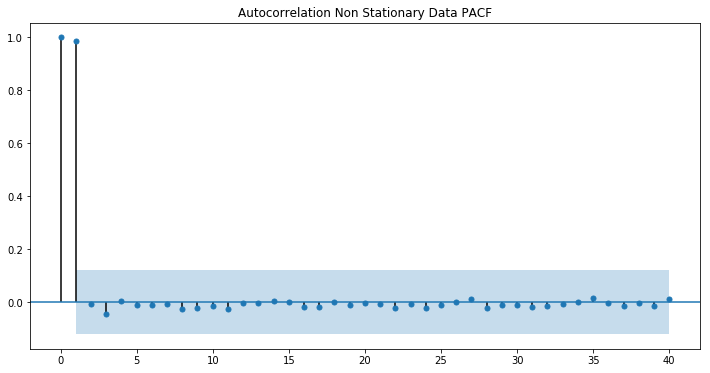

In [96]:
from statsmodels.graphics.tsaplots import plot_pacf
# just 40 lags is enough
# shaded region is a 95 percent confidence interval
# Correlation values OUTSIDE of this confidence interval are VERY HIGHLY LIKELY to be a CORRELATION
plot_pacf(df1['Inventories'],lags=40,title='Autocorrelation Non Stationary Data PACF');

#### 3.1 Conclusions

[How to Choose p and q for ARIMA Model](https://people.duke.edu/~rnau/411arim3.htm)

__Watching the Plots:__

- p = 1
- q = 0 we also test 1 
- And from Dickey-Fuller we know that i = 1

### 4. Train Test Split

In [97]:
len(df1)

264

In [98]:
# If We want to forecast one year (12 months), then our Testing Dataset has to be => 12 months
train = df1.iloc[:252]
test = df1.iloc[252:]

### 5. ARIMA Model

In [99]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

In [100]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.394
Method:                       css-mle   S.D. of innovations           4845.012
Date:                Fri, 03 May 2019   AIC                           4980.788
Time:                        17:53:12   BIC                           4994.890
Sample:                    02-01-1997   HQIC                          4986.463
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3223.4646   1344.859      2.397      0.017     587.590    5859.339
ar.L1.D.Inventories     0.9026      0.039     23.012      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

### 6. Predictions

In [101]:
start = len(train)
end = len(train) + len(test) - 1
# typ= 'levels' to return the differenced values to the original units
preds = results.predict(start=start,end=end,typ='levels').rename('ARIMA (1,1,1) Predictions')
preds

2018-01-01    2.107154e+06
2018-02-01    2.110540e+06
2018-03-01    2.113909e+06
2018-04-01    2.117265e+06
2018-05-01    2.120607e+06
2018-06-01    2.123938e+06
2018-07-01    2.127259e+06
2018-08-01    2.130570e+06
2018-09-01    2.133873e+06
2018-10-01    2.137167e+06
2018-11-01    2.140455e+06
2018-12-01    2.143737e+06
Freq: MS, Name: ARIMA (1,1,1) Predictions, dtype: float64

### 7. Plotting

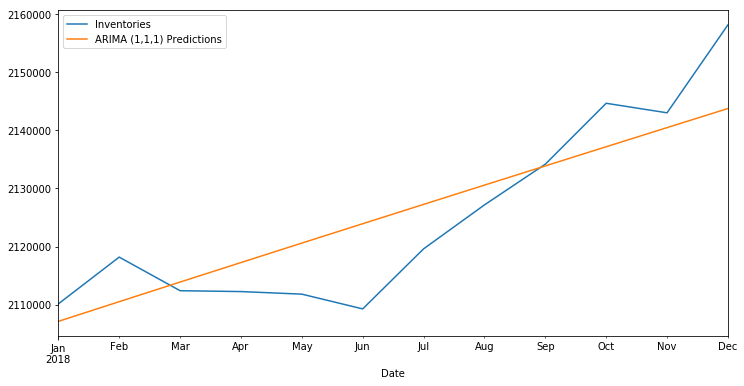

In [102]:
test['Inventories'].plot(figsize=(12,6),legend=True)
preds.plot(legend=True);

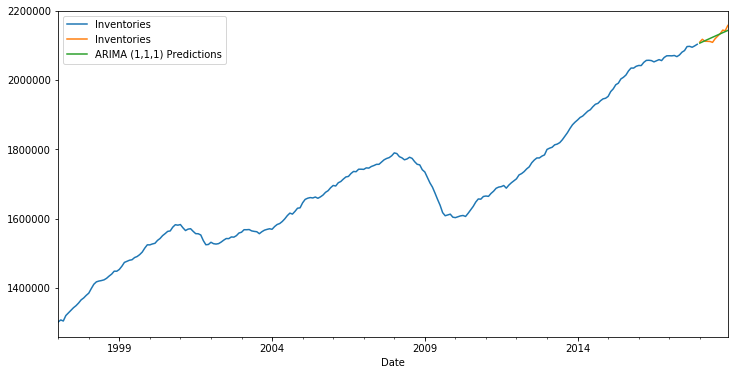

In [103]:
train['Inventories'].plot(figsize=(12,6),legend=True)
test['Inventories'].plot(legend=True)
preds.plot(legend=True);

### 8. Evaluate the Model

In [104]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['Inventories'],preds)
error

7773.582588671392

In [105]:
test['Inventories'].mean()

2125075.6666666665

In [106]:
(error/test['Inventories'].mean()) *100

0.36580262578907663

### 9. Forecast for Future Data

In [107]:
# Refit with all the Data
model = ARIMA(df1['Inventories'],order=(1,1,1)) # Order is chosen from Pyramid ARIMA
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Fri, 03 May 2019   AIC                           5228.505
Time:                        17:53:13   BIC                           5242.794
Sample:                    02-01-1997   HQIC                          5234.247
                         - 12-01-2018                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3463.1822   1313.137      2.637      0.009     889.481    6036.884
ar.L1.D.Inventories     0.9037      0.039     23.413      0.000       0.828       0.979
ma.L1.D.Inventories    -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

In [108]:
start = len(df1)
end = len(df1) + 12
# typ= 'levels' to return the differenced values to the original units
forecasted_values = results.predict(start=start,end=end,typ='levels').rename('ARIMA (1,1,1) Forecast')

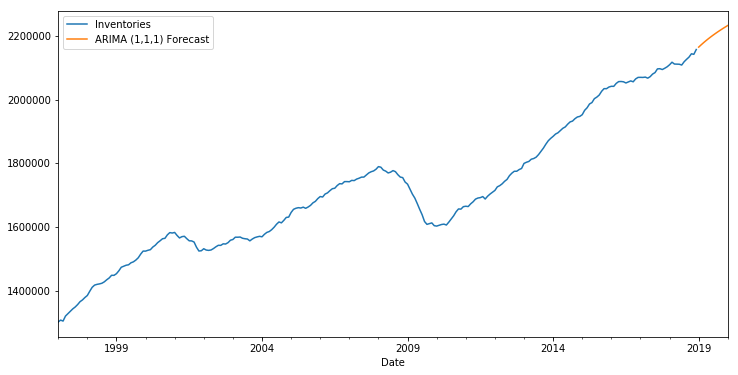

In [109]:
 df1['Inventories'].plot(figsize=(12,6),legend=True)
forecasted_values.plot(legend=True);